In [1]:
import Learn2_new as ln
ut = ln.ut # utilities
ef = ln.ef # ERA_Fields_New

# log to stdout
import logging
import sys
import os
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]

# set spacing of the indentation
ut.indentation_sep = '  '

2023-01-24 09:52:22.841117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap


## Dealing with parameters

The structure of `Learn2_new.py` is pretty nested, with functions calling other functions in such a way that changing a parameter seems difficult.
The best way to do so is by using the functions `ln.get_default_params` and `ut.set_values_recursive`

### Beginner approach

The first way of approaching the code is by looking at the documentation of its functions, and when they have an argument of kind `*_kwargs`, it means that the function `*` will be called, so you can then look at its documentation and so on

Let's say you want to use the function `ln.prepare_data`. If you look at its documentation you get

In [2]:
help(ln.prepare_data)

Help on function prepare_data in module Learn2_new:

prepare_data(load_data_kwargs=None, prepare_XY_kwargs=None)
    Combines all the steps from loading the data to the creation of X and Y
    
    Parameters
    ----------
    load_data_kwargs: dict
        arguments to pass to the function `load_data`
    prepare_XY_kwargs: dict
        arguments to pass to the function `prepare_XY`
        
    Returns
    -------
    X : np.ndarray
        data. If flatten_time_axis with shape (days, lat, lon, fields), else (years, days, lat, lon, fields)
    Y : np.ndarray 
        labels. If flatten_time_axis with shape (days,), else (years, days)
    year_permutation : np.ndarray
        with shape (years,), final permutaion of the years that reproduces X and Y once applied to the just loaded data
    lat
    lon



This functions calls `ln.load_data` and `ln.prepare_XY`.

In [3]:
help(ln.load_data)

Help on function load_data in module Learn2_new:

load_data(dataset_years=8000, year_list=None, sampling='', Model='Plasim', area='France', filter_area='France', lon_start=-64, lon_end=64, lat_start=0, lat_end=22, mylocal='/local/gmiloshe/PLASIM/', fields=['t2m', 'zg500', 'mrso_filtered'], preprefix='ANO_', datafolder='Data_Plasim')
    Loads the data into Plasim_Fields objects
    
    Parameters
    ----------
    dataset_years : int, optional
        number of years of the dataset, for now 8000 or 1000.
    year_list : array-like or str or int or tuple or None, optional
        list of years to load from the dataset. If None all years are loaded
        if str must be in the format 'range([<start>],<end>,[<step>])', where square brackets mean the argument is optional. It will be interpreted as np.range([<start>],<end>,[<step>])
        if tuple must be in format ([<start>],<end>,[<step>])
        if int is just like providing only <end>
    sampling : str, optional
        '' (dayly

Note that the variable called `mylocal` governs the source of data. Depending on the machine we are using we might want to change it. For instance on r740server5, the local space is acutally: '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/';

In [4]:
help(ln.prepare_XY)

Help on function prepare_XY in module Learn2_new:

prepare_XY(fields, make_XY_kwargs=None, roll_X_kwargs=None, do_premix=False, premix_seed=0, do_balance_folds=True, nfolds=10, year_permutation=None, flatten_time_axis=True, return_time_series=False)
    Performs all operations to extract from the fields X and Y ready to be fed to the neural network.
    
    Parameters
    ----------
    fields : dict of ef.Plasim_Field objects
    make_XY_kwargs : dict
        arguments to pass to the function `make_XY`
    roll_X_kwargs : dict
        arguments to pass to the function `roll_X`
    do_premix : bool, optional
        whether to perform premixing, by default False
    premix_seed : int, optional
        seed for premixing, by default 0
    do_balance_folds : bool, optional
        whether to balance folds
    nfolds : int, optional
        necessary for balancing folds
    year_permutation : np.ndarray, optional
        if provided overrides both premixing and fold balancing, useful for

And `ln.prepare_XY` calls `ln.make_XY` and `ln.roll_X`

In [5]:
help(ln.make_XY)

Help on function make_XY in module Learn2_new:

make_XY(fields, label_field='t2m', time_start=30, time_end=120, T=14, tau=0, percent=5, threshold=None, label_period_start=None, label_period_end=None, A_weights=None, return_threshold=False)
    Combines `make_X` and `assign_labels`
    
    Parameters:
    -----------
    fields : dict of Plasim_Field objects
    label_field : str, optional
        key for the field used for computing labels
    time_start : int, optional
        first day of the period of interest
    time_end : int, optional
        first day after the end of the period of interst
    T : int, optional
        width of the window for the running average
    tau : int, optional
        delay between observation and prediction
    percent : float, optional
        percentage of the most extreme heatwaves
    threshold : float, optional
        if provided overrides `percent`
    label_period_start : int, optional
        if provided the first day of the period of intere

In [6]:
help(ln.roll_X)

Help on function roll_X in module Learn2_new:

roll_X(X, roll_axis='lon', roll_steps=0)
    Rolls `X` along a given axis. useful for example for moving France away from the Greenwich meridian.
    In other words this allows one, for example, to shift the grid so that desired areas are not found at the boundary.
    In principle this function allows us to roll along arbitrary axis, including days or years.
    
    Parameters
    ----------
    X : np.ndarray
        with shape (years, days, lat, lon, field)
    roll_axis : int or str, optional
        'year' (or 'y'), 'day' (or 'd'), 'lat', 'lon', 'field' (or 'f')
    roll_steps : int, optional
        number of gridsteps to roll: a positive value for `roll_steps` means that the elements of the array are moved forward in it,
        e.g. `roll_steps` = 1 means that the old first element is now in the second place
        This means that for every axis a positive value of `roll_steps` yields a shift of the array
        'year', 'day' : 

So, now let's say you want to call `ln.prepare_data` with just the temperature field, using data from the short 1000 years dataset and rolling `X` by 16 steps, leavingall other values at their default. One (cumbersome) way to do it is the following

In [7]:
import imp
imp.reload(ln)

path_to_ERA = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe'/ERA/


<module 'Learn2_new' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Learn2_new.py'>

In [8]:
X, Y, yp, lat, lon = ln.prepare_data(load_data_kwargs = {'fields': ['t2m'], 'dataset_years': 1000},
                           prepare_XY_kwargs = {'roll_X_kwargs': {'roll_steps': 16}})

prepare_data:
  load_data:
    Opening field tas
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim/ANO_tas.nc
    monotonize_years:
    monotonize_years: completed in 0.6 s
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_gparea.nc
    select_years:
    select_years: completed in 0.0 s
    select_lonlat:
    select_lonlat: completed in 3.1 s
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc
  load_data: completed in 19.7 s
  prepare_XY:
    return_threshold = False    
    make_XY:
      make_X:
      make_X: completed in 0.3 s
      assign_labels:
        A_weights = None
        compute_time_average:
          compute_area_integral:
          compute_area_integral: completed in 3.6 s
        compute_time_average: completed in 4.8 s
        threshold = 2.953485
      assign_labels: completed in 4.9 s
    make_XY: c

We can inspect the coordinates to see that they are indeed in rolled order

In [9]:
lon, lat

(array([-225.    , -222.1875, -219.375 , -216.5625, -213.75  , -210.9375,
        -208.125 , -205.3125, -202.5   , -199.6875, -196.875 , -194.0625,
        -191.25  , -188.4375, -185.625 , -182.8125, -180.    , -177.1875,
        -174.375 , -171.5625, -168.75  , -165.9375, -163.125 , -160.3125,
        -157.5   , -154.6875, -151.875 , -149.0625, -146.25  , -143.4375,
        -140.625 , -137.8125, -135.    , -132.1875, -129.375 , -126.5625,
        -123.75  , -120.9375, -118.125 , -115.3125, -112.5   , -109.6875,
        -106.875 , -104.0625, -101.25  ,  -98.4375,  -95.625 ,  -92.8125,
         -90.    ,  -87.1875,  -84.375 ,  -81.5625,  -78.75  ,  -75.9375,
         -73.125 ,  -70.3125,  -67.5   ,  -64.6875,  -61.875 ,  -59.0625,
         -56.25  ,  -53.4375,  -50.625 ,  -47.8125,  -45.    ,  -42.1875,
         -39.375 ,  -36.5625,  -33.75  ,  -30.9375,  -28.125 ,  -25.3125,
         -22.5   ,  -19.6875,  -16.875 ,  -14.0625,  -11.25  ,   -8.4375,
          -5.625 ,   -2.8125,    0.   

If this command didn't work it is likely that you are running it from a machine which doesn't have the data in local space, or as mentioned earlier R740server5, in which case you need to specify the source in kwargs by doing:

In [10]:
X, Y, yp, lat, lon = ln.prepare_data(load_data_kwargs = {'fields': ['t2m'], 'dataset_years': 1000, 'mylocal':  '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'},
                           prepare_XY_kwargs = {'roll_X_kwargs': {'rosteps': 16}})

prepare_data:
  load_data:
    Opening field tas
    First valid path found in /ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Data_Plasim/ANO_tas.nc
    monotonize_years:
    monotonize_years: completed in 0.7 s
    First valid path found in /ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc
    First valid path found in /ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_gparea.nc
    select_years:
    select_years: completed in 0.0 s
    select_lonlat:
    select_lonlat: completed in 1.9 s
    First valid path found in /ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc
  load_data: completed in 14.1 s
  prepare_XY:
    return_threshold = False    
    make_XY:
      make_X:
      make_X: completed in 0.3 s
      assign_labels:
        A_weights = None
        compute_time_average:
          compute_area_integral:
          compute_area_i

## Better approach

If intstead you already roughly know how the code works, you can proceed in a more elegant way

First create a dictionary of the default parameters using `ln.get_default_params`. Remeber to specify `recursive = True`, which will gather all the default parameters of the functions called in a nested manner

In [11]:
prepare_data_kwargs_default = ln.get_default_params(ln.prepare_data, recursive=True)
print(ut.dict2str(prepare_data_kwargs_default)) # a nice way of printing nested dictionaries

{
    "load_data_kwargs": {
        "dataset_years": 8000,
        "year_list": null,
        "sampling": "",
        "Model": "Plasim",
        "area": "France",
        "filter_area": "France",
        "lon_start": -64,
        "lon_end": 64,
        "lat_start": 0,
        "lat_end": 22,
        "mylocal": "/local/gmiloshe/PLASIM/",
        "fields": [
            "t2m",
            "zg500",
            "mrso_filtered"
        ],
        "preprefix": "ANO_",
        "datafolder": "Data_Plasim"
    },
    "prepare_XY_kwargs": {
        "do_premix": false,
        "premix_seed": 0,
        "do_balance_folds": true,
        "nfolds": 10,
        "year_permutation": null,
        "flatten_time_axis": true,
        "return_time_series": false,
        "make_XY_kwargs": {
            "label_field": "t2m",
            "time_start": 30,
            "time_end": 120,
            "T": 14,
            "tau": 0,
            "percent": 5,
            "threshold": null,
            "label_period_s

In [12]:
def keys_exists(d_nested, key):
    '''
    Check if *keys (nested) exists in `element` (dict). This is basically like extract_nested() but does not raise the KeyError as the output
    '''
    try: 
        _element = ut.extract_nested(d_nested, key)
        return True
    except KeyError:
        return False

keys_exists(prepare_data_kwargs_default, 'year_list2')

False

In [13]:
ut.extract_nested(prepare_data_kwargs_default, 'lat_end2')

KeyError: 'lat_end2 is not a valid key'

(Again pay attention that the machine we are using has the data in space called 'local'. If so you don't need to specify the variable `mylocal` below)

Now you want to set the two parameters to non default values, and you can do it by using `ut.set_values_recursive`, without needing to account for the level of nestedness of the parameter.

In [14]:
prepare_data_kwargs = ut.set_values_recursive(prepare_data_kwargs_default,
                                              {'fields': ['t2m'], 'year_list' : 'range(100)'}) #, 'mylocal': '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'})
print(ut.dict2str(prepare_data_kwargs))

{
    "load_data_kwargs": {
        "dataset_years": 8000,
        "year_list": "range(100)",
        "sampling": "",
        "Model": "Plasim",
        "area": "France",
        "filter_area": "France",
        "lon_start": -64,
        "lon_end": 64,
        "lat_start": 0,
        "lat_end": 22,
        "mylocal": "/local/gmiloshe/PLASIM/",
        "fields": [
            "t2m"
        ],
        "preprefix": "ANO_",
        "datafolder": "Data_Plasim"
    },
    "prepare_XY_kwargs": {
        "do_premix": false,
        "premix_seed": 0,
        "do_balance_folds": true,
        "nfolds": 10,
        "year_permutation": null,
        "flatten_time_axis": true,
        "return_time_series": false,
        "make_XY_kwargs": {
            "label_field": "t2m",
            "time_start": 30,
            "time_end": 120,
            "T": 14,
            "tau": 0,
            "percent": 5,
            "threshold": null,
            "label_period_start": null,
            "label_period_end

And then you can run

In [15]:
X, Y, yp, lat, lon = ln.prepare_data(**prepare_data_kwargs)

prepare_data:
  load_data:
    Opening field tas
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_LONG/ANO_LONG_tas.nc
    monotonize_years:
    monotonize_years: completed in 3.9 s
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_gparea.nc
    select_years:
    select_years: completed in 0.9 s
    select_lonlat:
    select_lonlat: completed in 0.2 s
    First valid path found in /local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc
  load_data: completed in 2 min 7.4 s
  prepare_XY:
    return_threshold = False    
    make_XY:
      make_X:
      make_X: completed in 0.0 s
      assign_labels:
        A_weights = None
        compute_time_average:
          compute_area_integral:
          compute_area_integral: completed in 0.2 s
        compute_time_average: completed in 0.3 s
        threshold = 2.806813
      assign_labels: completed in 0.3 s

### Loading parameters from a config file

If you want to load your default values from a config file, you can do as follows

In [16]:
config_dict = ut.json2dict('example_config.json') # load the config file
print(ut.dict2str(config_dict))
print('\n\n')
config_dict_flat = ut.collapse_dict(config_dict) # flatten the dictionary
print(ut.dict2str(config_dict_flat))

{
    "run_kwargs": {
        "log_level": 20,
        "load_data_kwargs": {
            "dataset_years": 8000,
            "year_list": null,
            "sampling": "",
            "Model": "Plasim",
            "area": "France",
            "filter_area": "France",
            "lon_start": 0,
            "lon_end": 128,
            "lat_start": 0,
            "lat_end": 22,
            "mylocal": "/local/gmiloshe/PLASIM/",
            "fields": [
                "t2m",
                "zg500",
                "mrso_filtered"
            ]
        },
        "prepare_XY_kwargs": {
            "do_premix": false,
            "premix_seed": 0,
            "do_balance_folds": true,
            "nfolds": 10,
            "year_permutation": null,
            "flatten_time_axis": true,
            "make_XY_kwargs": {
                "label_field": "t2m",
                "time_start": 30,
                "time_end": 120,
                "T": 14,
                "tau": 0,
                "pe

In [17]:
ut.set_values_recursive(prepare_data_kwargs_default, config_dict_flat, inplace=True) # set all values in prepare_data_kwargs_default to the one that appear in config_dict_flat
print(ut.dict2str(prepare_data_kwargs_default))

{
    "load_data_kwargs": {
        "dataset_years": 8000,
        "year_list": null,
        "sampling": "",
        "Model": "Plasim",
        "area": "France",
        "filter_area": "France",
        "lon_start": 0,
        "lon_end": 128,
        "lat_start": 0,
        "lat_end": 22,
        "mylocal": "/local/gmiloshe/PLASIM/",
        "fields": [
            "t2m",
            "zg500",
            "mrso_filtered"
        ],
        "preprefix": "ANO_",
        "datafolder": "Data_Plasim"
    },
    "prepare_XY_kwargs": {
        "do_premix": false,
        "premix_seed": 0,
        "do_balance_folds": true,
        "nfolds": 10,
        "year_permutation": null,
        "flatten_time_axis": true,
        "return_time_series": false,
        "make_XY_kwargs": {
            "label_field": "t2m",
            "time_start": 30,
            "time_end": 120,
            "T": 14,
            "tau": 0,
            "percent": 5,
            "threshold": null,
            "label_period_st

We had to do this way because `prepare_data_kwargs` is not a key of the config dictionary. Let's say instead you wanted the default arguments for the function `make_XY`, you could have simply done

In [18]:
make_XY_kwargs_default = ut.extract_nested(config_dict, 'make_XY_kwargs')
print(ut.dict2str(make_XY_kwargs_default))

{
    "label_field": "t2m",
    "time_start": 30,
    "time_end": 120,
    "T": 14,
    "tau": 0,
    "percent": 5,
    "threshold": null
}


Where the function `ut.extract_nested` allows to obtain a key from a nested dictionary regardless of the level of indentation

In [19]:
lat

array([87.86379884, 85.09652699, 82.31291295, 79.52560657, 76.73689968,
       73.94751515, 71.15775201, 68.36775611, 65.57760701, 62.7873518 ,
       59.99702011, 57.20663153, 54.41619953, 51.62573367, 48.83524097,
       46.04472663, 43.25419467, 40.46364818, 37.67308963, 34.88252099,
       32.09194388, 29.30135962])

# Plotting tools

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7f79fb6aeee0>


/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/general_purpose/cartopy_plots.py:138: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


<GeoAxesSubplot:>

<Figure size 648x432 with 0 Axes>

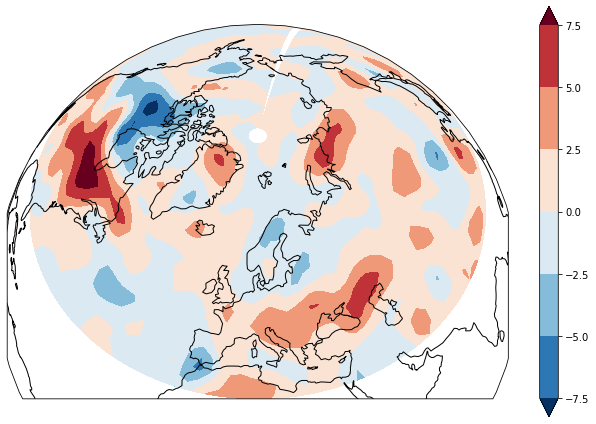

In [20]:
import cartopy.crs as ccrs
import general_purpose.cartopy_plots as cplt
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
LON, LAT = np.meshgrid(lon,lat)
cplt.multiple_field_plot2(LON, LAT, X[0,...],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True,
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

In [22]:
import xarray as xr
dtset = xr.open_dataset('/local/gmiloshe/PLASIM/Data_Plasim_LONG/LONG_tas.nc')

In [27]:
_latitudes = dtset.lat.isel(lat=slice(None, None))
_latitudes = _latitudes.sortby(_latitudes, ascending=True)
_latitudes

<xarray.DataArray 'lat' (lat: 64)>
array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369  , -73.947515,
       -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
       -54.4162  , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
       -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
       -20.929574, -18.138971, -15.348365, -12.557756,  -9.767146,  -6.976534,
        -4.185921,  -1.395307,   1.395307,   4.185921,   6.976534,   9.767146,
        12.557756,  15.348365,  18.138971,  20.929574,  23.720174,  26.510769,
        29.30136 ,  32.091944,  34.882521,  37.67309 ,  40.463648,  43.254195,
        46.044727,  48.835241,  51.625734,  54.4162  ,  57.206632,  59.99702 ,
        62.787352,  65.577607,  68.367756,  71.157752,  73.947515,  76.7369  ,
        79.525607,  82.312913,  85.096527,  87.863799])
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

# Working with the `Trainer` Class

Instead of using the module level functions such as `load_data` or `train_model`, you can use the `Trainer` class to a simpler training of the networks and efficient over multiple runs.

First create a `Trainer` object in a given work directory. You can avoid the work directory if don't plan to train networks

Then you can call the equivalent of module level functions `t.prepare_data`, `t.prepare_XY`, `t.load_data`. If you call them multiple times with the same arguments the values will be cached, the values will be cached so you will save time.

In [2]:
# create a work directory
work_dir = './test'

t = ln.Trainer(work_dir)

tf.__version__ = '2.4.1'
tf.config.list_physical_devices('GPU') = []


/Users/alessandrolovo/Repos/Climate-Learning/PLASIM/Learn2_new.py:1820: UserWarning: 
This machine does not have a GPU: training may be very slow

  warnings.warn('\nThis machine does not have a GPU: training may be very slow\n')


Be careful if you want to train convolutional networks that the machine you are using has a GPU, otherwise training will be very slow

The most interesting part is however related to performing full runs. First setup the config dictionary of the trainer object, for example here we want a specific network architecture

In [9]:
print(ut.dict2str(ut.extract_nested(t.config_dict, 'create_model_kwargs')))

{
    "conv_channels": [
        32,
        64,
        64
    ],
    "kernel_sizes": 3,
    "strides": 1,
    "batch_normalizations": true,
    "conv_activations": "relu",
    "conv_dropouts": 0.2,
    "max_pool_sizes": [
        2,
        2,
        false
    ],
    "dense_units": [
        64,
        2
    ],
    "dense_activations": [
        "relu",
        null
    ],
    "dense_dropouts": [
        0.2,
        false
    ]
}


In [ ]:
d = {
    'conv_channels': [64, 24], # set number of convolutional kernels per layer
    'kernel_sizes': [7, 3],
    'strides': [3, 2],
    'batch_normalization': False, # disable batch normalization
    'max_pool_sizes': False, # disable max pool
    'conv_dropout': False, # disable dropout in the convolutional layer

    'dense_units': [128, 64, 16, 2], # number of neurons per fully connected layer
    'dense_dropouts': [0.5, 0.5, 0.1, 0],
    'dense_activations': ['relu', 'relu', 'relu', None]
}

ut.set_values_recursive(t.config_dict, d, inplace=True)
print(ut.dict2str(t.config_dict))

Then you can schedule your runs, for example iterating over `tau` at two different `percent` levels, transfer learning from the last network with the same value for `percent`

In [19]:
t.schedule(percent=[5,1], tau=[0, -5, -10, -15, -20, -25, -30], load_from='last--percent__same')

Scheduled the following 14 runs:
0: {'load_from': 'last--percent__same'}
1: {'load_from': 'last--percent__same', 'tau': -5}
2: {'load_from': 'last--percent__same', 'tau': -10}
3: {'load_from': 'last--percent__same', 'tau': -15}
4: {'load_from': 'last--percent__same', 'tau': -20}
5: {'load_from': 'last--percent__same', 'tau': -25}
6: {'load_from': 'last--percent__same', 'tau': -30}
7: {'load_from': 'last--percent__same', 'percent': 1}
8: {'load_from': 'last--percent__same', 'percent': 1, 'tau': -5}
9: {'load_from': 'last--percent__same', 'percent': 1, 'tau': -10}
10: {'load_from': 'last--percent__same', 'percent': 1, 'tau': -15}
11: {'load_from': 'last--percent__same', 'percent': 1, 'tau': -20}
12: {'load_from': 'last--percent__same', 'percent': 1, 'tau': -25}
13: {'load_from': 'last--percent__same', 'percent': 1, 'tau': -30}


In [ ]:
t.run_multiple()